In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
pd.options.display.max_rows = 8000    # data has 7214 rows

url = 'https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv?raw=true'

# Dressel et al. found that the 2 features, age + num of priors, used in LR performed as well as COMPAS
# two_year_recid is ground truth
df = pd.read_csv(url, usecols = ['age', 'race', 'priors_count', 'two_year_recid'])

# Filter-out non-white/black defendents
df_race = df[(df['race'] == 'Caucasian') | (df['race'] == 'African-American')]

# Split data train 80%, test 20%. Not a random split (which isn't best practice...) but helps with reproducibility.
train_num = int(len(df_race) * 0.8)

df_1 = df.iloc[:train_num,:]
df_2 = df.iloc[train_num:,:]

X_train, X_test = df_1[['age','priors_count']].to_numpy(), df_2[['age','priors_count']].to_numpy()
y_train, y_test = df_1['two_year_recid'].to_numpy(), df_2['two_year_recid'].to_numpy()

## Visualize Dataset

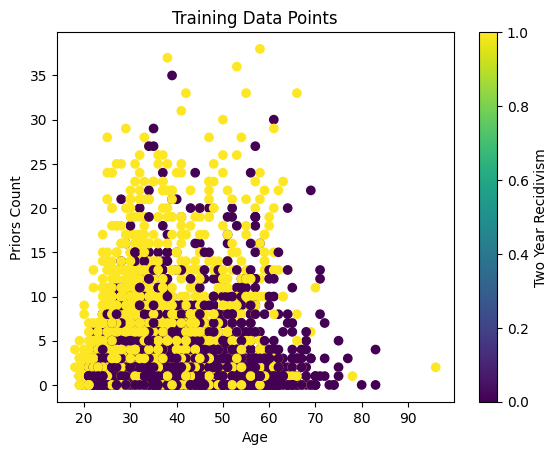

In [3]:
# Plotting the training data points
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Priors Count')
plt.title('Training Data Points')

# Create a colorbar legend
plt.colorbar(scatter, label='Two Year Recidivism')

# Display the plot
plt.show()

## Create model class

In [4]:
class LogisticRegression(torch.nn.Module):

     def __init__(self):
         super(LogisticRegression, self).__init__()

         self.linear = torch.nn.Linear(2, 1)

     def forward(self, x):

         outputs = torch.sigmoid(self.linear(x)) # output will be either 0 or 1
         return outputs

In [5]:
epochs = 10000
lr_rate = 0.01

# Instantiate model class
model = LogisticRegression()

# Instantiate loss class
criterion = torch.nn.BCELoss()

# Instantiate optimizer class
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [6]:
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

## Train model

In [7]:
for epoch in range(int(epochs)):

    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), y_train) # [200,1] -squeeze-> [200]

    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves

    optimizer.step() # Updates weights and biases with the optimizer (Adam)

## Visualize Logistic Regression

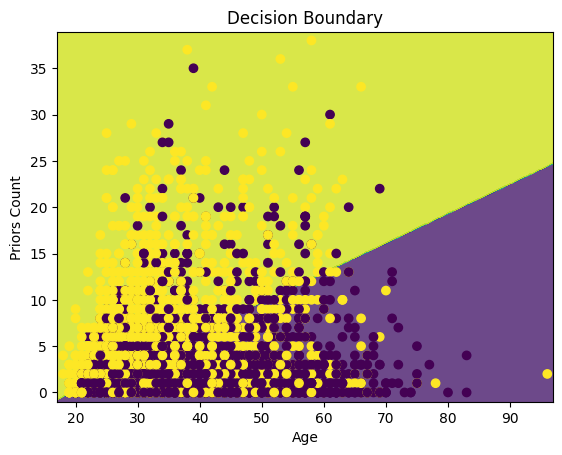

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate mesh grid
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Pass grid points through the model
with torch.no_grad():
    grid_points_tensor = torch.Tensor(grid_points)
    probabilities = model(grid_points_tensor)
    predicted_labels = (probabilities >= 0.5).float().numpy()

# Reshape predicted_labels to match the mesh grid shape
predicted_labels = predicted_labels.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, predicted_labels, alpha=0.8, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Priors Count')
plt.title('Decision Boundary')

plt.show()

## Confusion Matrix

In [9]:
pd.options.display.max_rows = 8000    # data has 7214 rows

url = 'https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv?raw=true'

# Dressel et al. found that the 2 features, age + num of priors, used in LR performed as well as COMPAS
# two_year_recid is ground truth
df = pd.read_csv(url, usecols = ['age', 'race', 'priors_count', 'two_year_recid'])

# Filter-out non-white/black defendents
df_race = df[(df['race'] == 'Caucasian') | (df['race'] == 'African-American')]

# Split data train 80%, test 20%. Not a random split (which isn't best practice...) but helps with reproducibility.
train_num = int(len(df_race) * 0.8)

df_1 = df.iloc[:train_num,:]
df_2 = df.iloc[train_num:,:]

X_train, X_test = df_1[['age','priors_count']].to_numpy(), df_2[['age','priors_count']].to_numpy()
y_train, y_test = df_1['two_year_recid'].to_numpy(), df_2['two_year_recid'].to_numpy()

X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

In [10]:
from sklearn.metrics import confusion_matrix

# Convert predicted probabilities to predicted labels
with torch.no_grad():
    predicted_labels_train = (model(X_train) >= 0.5).float().numpy()
    predicted_labels_test = (model(X_test) >= 0.5).float().numpy()

# Create confusion matrix
confusion_matrix_train = confusion_matrix(y_train, predicted_labels_train)
confusion_matrix_test = confusion_matrix(y_test, predicted_labels_test)

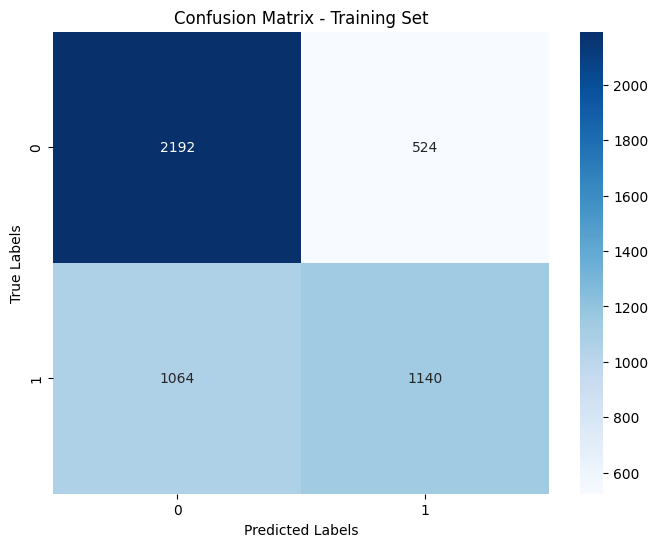

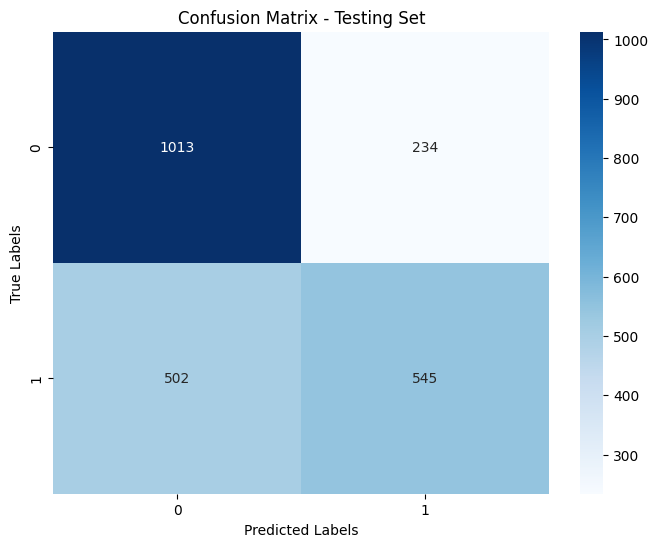

In [11]:
import seaborn as sns

# Create a heatmap for the training set confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_train, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Create a heatmap for the testing set confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Testing Set')
plt.show()

## Accuracy, Precision, Recall, F1

In [12]:
# Extract values from confusion matrix
TP = confusion_matrix_train[1, 1]  # True Positives
TN = confusion_matrix_train[0, 0]  # True Negatives
FP = confusion_matrix_train[0, 1]  # False Positives
FN = confusion_matrix_train[1, 0]  # False Negatives

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.6772357723577236
Precision: 0.6850961538461539
Recall: 0.5172413793103449
F1 Score: 0.5894519131334023


In [13]:
# Extract values from confusion matrix
TP = confusion_matrix_test[1, 1]  # True Positives
TN = confusion_matrix_test[0, 0]  # True Negatives
FP = confusion_matrix_test[0, 1]  # False Positives
FN = confusion_matrix_test[1, 0]  # False Negatives

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.6791630340017437
Precision: 0.699614890885751
Recall: 0.5205348615090736
F1 Score: 0.5969331872946332


## AUC-ROC

In [14]:
from sklearn.metrics import roc_auc_score

#get the true labels
true_labels_train = df['two_year_recid'][:X_train.shape[0]].values.squeeze()
true_labels_test = df['two_year_recid'][X_train.shape[0]:].values.squeeze()

# get the positive predictive probabilities
model.eval()
with torch.no_grad():
  positive_probabilities_train = torch.sigmoid(model(X_train)).numpy().squeeze()
  positive_probabilities_test = torch.sigmoid(model(X_test)).numpy().squeeze()

# Calculate AUC-ROC scores
auc_roc_train = roc_auc_score(true_labels_train, positive_probabilities_train)
auc_roc_test = roc_auc_score(true_labels_test, positive_probabilities_test)

print("AUC-ROC of train:", auc_roc_train)
print("AUC-ROC of test:", auc_roc_test)

AUC-ROC of train: 0.7193680187849645
AUC-ROC of test: 0.7284811149432947


## Fairness Metrics

In [15]:
# Find white and black defendents in df_2, the test dataset
white_def = df_2[df_2['race'] == 'Caucasian']
black_def = df_2[df_2['race'] == 'African-American']

white_data, black_data = white_def[['age','priors_count']].to_numpy(), black_def[['age','priors_count']].to_numpy()
white_label, black_label = white_def['two_year_recid'].to_numpy(), black_def['two_year_recid'].to_numpy()

In [16]:
# Get stats on white defendents

TP_W, FP_W, FN_W, TN_W = 0, 0, 0, 0

for i in range(len(white_data)):
    new_data = torch.tensor(white_data[i]).type(torch.FloatTensor)
    with torch.no_grad():
        prediction = model(new_data).round()
        # correctly predicted to recidivate (TP)
        if prediction == 1.0 and white_label[i] == 1.0:
            TP_W += 1
        # wrongly predicted to recidivate (FP)
        elif prediction == 1.0 and white_label[i] == 0.0:
            FP_W += 1
        # wrongly predicted to not recidivate (FN)
        elif prediction == 0.0 and white_label[i] == 1.0:
            FN_W += 1
        # correctly predicted to not recidivate (TN)
        elif prediction == 0.0 and white_label[i] == 0.0:
            TN_W += 1
        else:
            print('something is wrong')

print(f'Probability that a white defendent who got a score of 1 recidivates in 2 years: {TP_W/(TP_W+FP_W)}')

Probability that a white defendent who got a score of 1 recidivates in 2 years: 0.6593406593406593


In [17]:
# Get stats on black defendents

TP_B, FP_B, FN_B, TN_B = 0, 0, 0, 0

for i in range(len(black_data)):
    new_data = torch.tensor(black_data[i]).type(torch.FloatTensor)
    with torch.no_grad():
        prediction = model(new_data).round()
        # correctly predicted to recidivate
        if prediction == 1.0 and black_label[i] == 1.0:
            TP_B += 1
        # wrongly predicted to recidivate
        elif prediction == 1.0 and black_label[i] == 0.0:
            FP_B += 1
        # wrongly predicted to not recidivate
        elif prediction == 0.0 and black_label[i] == 1.0:
            FN_B += 1
        # correctly predicted to not recidivate
        elif prediction == 0.0 and black_label[i] == 0.0:
            TN_B += 1
        else:
            print('something is wrong')

print(f'Probability that a black defendent who got a score of 1 recidivates in 2 years: {TP_B/(TP_B+FP_B)}')


Probability that a black defendent who got a score of 1 recidivates in 2 years: 0.7117988394584139


In [18]:
# Calculate positive prediction rate for each group
PPR_W = (TP_W + FP_W) / (TN_W + FP_W + FN_W + TP_W)
PPR_B = (TP_B + FP_B) / (TN_B + FP_B + FN_B + TP_B)

print(PPR_W)
print(PPR_B)

# Compare the proportion of positive predictions for each group
if PPR_W == PPR_B:
    print("Statistical parity is achieved.")
else:
    print("Statistical parity is not achieved.")
    if PPR_W > PPR_B:
      print("Positive prediction rate for white people is %1.2f%% higher than PPR for black people." % ((PPR_W - PPR_B) * 100))
    else:
      print("Positive prediction rate for black people is %1.2f%% higher than PPR for white people." % ((PPR_B - PPR_W) * 100))

0.23544631306597671
0.44112627986348124
Statistical parity is not achieved.
Positive prediction rate for black people is 20.57% higher than PPR for white people.
